In [1]:
import sys

import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, losses, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Lambda

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

%matplotlib inline
%reload_ext nb_black

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [2]:
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tf.__version__)

Python:  3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]
pandas:  1.1.5
numpy:  1.18.5
seaborn:  0.11.0
sklearn:  0.23.2
Keras:  2.4.0
Tensorflow:  2.3.1


<IPython.core.display.Javascript object>

In [3]:
class VisualizationHelper:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors = ["orange", "green"]
        sns.heatmap(
            matrix,
            xticklabels=self.labels,
            yticklabels=self.labels,
            cmap=colors,
            annot=True,
            fmt="d",
        )
        plt.title("Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({"error": error, "true": y}).groupby("true")

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(
                group.index,
                group.error,
                marker="x" if name == 1 else "o",
                linestyle="",
                color="r" if name == 1 else "g",
                label="Anomaly" if name == 1 else "Normal",
            )

        axes.hlines(
            threshold,
            axes.get_xlim()[0],
            axes.get_xlim()[1],
            colors="b",
            zorder=100,
            label="Threshold",
        )
        axes.legend()

        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.plot(error, marker="o", ms=3.5, linestyle="", label="Point")

        plt.hlines(
            threshold,
            xmin=0,
            xmax=len(error) - 1,
            colors="b",
            zorder=100,
            label="Threshold",
        )
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

<IPython.core.display.Javascript object>

## Prepare Data

In [4]:
df = pd.read_csv("data/creditcard.csv")

<IPython.core.display.Javascript object>

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<IPython.core.display.Javascript object>

In [6]:
df.shape

(284807, 31)

<IPython.core.display.Javascript object>

In [7]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

<IPython.core.display.Javascript object>

#### Scale features

In [8]:
df["Amount"] = StandardScaler().fit_transform(df.Amount.values.reshape(-1, 1))

<IPython.core.display.Javascript object>

In [9]:
# Take 20K normal and 492 fraud cases
df_sample = pd.concat([df[df.Class == 0].sample(20000), df[df.Class == 1]])

<IPython.core.display.Javascript object>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_sample.drop(columns=["Time", "Class"], axis=1),
    df_sample.Class,
    stratify=df_sample.Class,
    test_size=0.2,
    random_state=42,
)

<IPython.core.display.Javascript object>

## Model

#### Hyperparameters

In [12]:
ENCODING_DIM = 12
BATCH_SIZE = 32
EPOCHS = 20

<IPython.core.display.Javascript object>

In [13]:
def create_autoencoder_model(input_dim: int) -> Model:

    inputArray = Input(shape=(input_dim,))

    encoder = Dense(
        ENCODING_DIM, activation="relu", kernel_regularizer=regularizers.l1(10e-5)
    )(inputArray)
    decoder = Dense(input_dim, activation="softmax")(encoder)

    autoencoder = Model(inputArray, decoder)

    return autoencoder

<IPython.core.display.Javascript object>

In [14]:
autoencoder_model = create_autoencoder_model(X_train.shape[1])

<IPython.core.display.Javascript object>

In [15]:
autoencoder_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 12)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 29)                377       
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [16]:
autoencoder_model.compile(
    optimizer=optimizers.RMSprop(),
    loss="mean_squared_error",
    metrics=["mae", "accuracy"],
)

<IPython.core.display.Javascript object>

In [17]:
#### Train Model

<IPython.core.display.Javascript object>

In [18]:
history = autoencoder_model.fit(
    X_train,
    X_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    validation_data=(X_test, X_test),
)

Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 1.6492 - mae: 0.6890 - accuracy: 0.2849 - val_loss: 1.5476 - val_mae: 0.6675 - val_accuracy: 0.4594
Epoch 2/20
513/513 [==============================] - 0s 710us/step - loss: 1.5954 - mae: 0.6723 - accuracy: 0.5240 - val_loss: 1.5209 - val_mae: 0.6617 - val_accuracy: 0.6040
Epoch 3/20
513/513 [==============================] - 0s 712us/step - loss: 1.5801 - mae: 0.6695 - accuracy: 0.6256 - val_loss: 1.5126 - val_mae: 0.6605 - val_accuracy: 0.6709
Epoch 4/20
513/513 [==============================] - 0s 701us/step - loss: 1.5745 - mae: 0.6686 - accuracy: 0.6936 - val_loss: 1.5090 - val_mae: 0.6598 - val_accuracy: 0.7185
Epoch 5/20
513/513 [==============================] - 0s 728us/step - loss: 1.5717 - mae: 0.6682 - accuracy: 0.7304 - val_loss: 1.5066 - val_mae: 0.6596 - val_accuracy: 0.7497
Epoch 6/20
513/513 [==============================] - 0s 724us/step - loss: 1.5702 - mae: 0.6680 - accuracy: 0.7499 - val_

<IPython.core.display.Javascript object>

In [19]:
### Evaluate Model

<IPython.core.display.Javascript object>

In [20]:
score = autoencoder_model.evaluate(X_test, X_test, verbose=1)

129/129 [==============================] - 0s 506us/step - loss: 1.5023 - mae: 0.6592 - accuracy: 0.7921


<IPython.core.display.Javascript object>

In [21]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[2])

Test Loss: 1.5022578239440918
Test Accuracy: 0.7921444177627563


<IPython.core.display.Javascript object>

In [22]:
THRESHOLD = 15.0

<IPython.core.display.Javascript object>

In [23]:
def generate_labels(model: Model, data: np.array) -> (list, list):
    y_pred = model.predict(data)

    y_dist = np.linalg.norm(data - y_pred, axis=-1)
    predictions = zip(y_dist >= THRESHOLD, y_dist)

    labels = []
    er = []

    for is_anomaly, dist in predictions:
        if is_anomaly:
            labels.append(1)
        else:
            labels.append(0)

        er.append(dist)

    return labels, er

<IPython.core.display.Javascript object>

#### Visualize errors

In [24]:
y_label, errors = generate_labels(autoencoder_model, X_test)

<IPython.core.display.Javascript object>

In [25]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4001
           1       0.61      0.60      0.61        98

    accuracy                           0.98      4099
   macro avg       0.80      0.80      0.80      4099
weighted avg       0.98      0.98      0.98      4099



<IPython.core.display.Javascript object>

In [26]:
roc_auc_score(y_test, y_label)

0.796396564124275

<IPython.core.display.Javascript object>

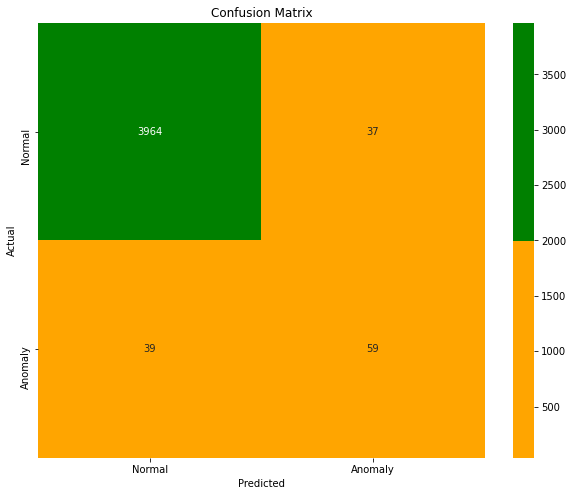

<IPython.core.display.Javascript object>

In [27]:
VisualizationHelper().draw_confusion_matrix(y_test, y_label)

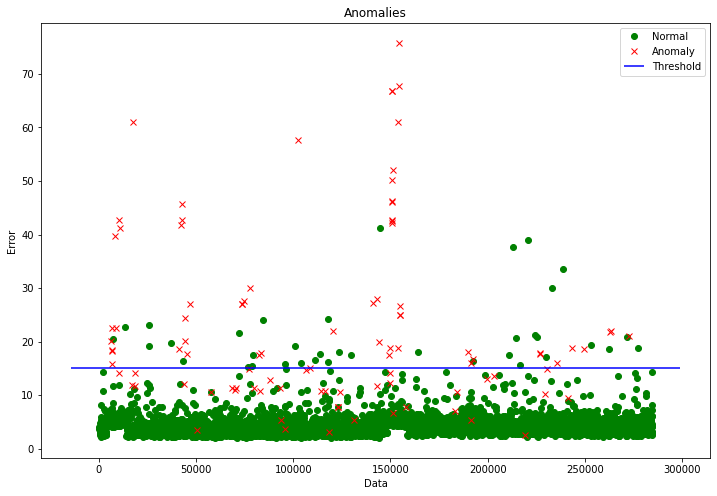

<IPython.core.display.Javascript object>

In [28]:
VisualizationHelper().draw_anomaly(y_test, errors, THRESHOLD)

## Deep AutoEncoder Model

In [29]:
ENCODING_DIM = 16
EPOCHS = 20

<IPython.core.display.Javascript object>

In [30]:
def create_deep_autoencoder_model(input_dim: int) -> Model:

    inputArray = Input(shape=(input_dim,))

    encoder = Dense(
        units=ENCODING_DIM, activation="relu", kernel_regularizer=regularizers.l1(10e-5)
    )(inputArray)
    encoder = Dense(units=8, activation="relu")(encoder)
    encoder = Dense(units=4, activation="relu")(encoder)

    decoder = Dense(units=8, activation="relu")(encoder)
    decoder = Dense(units=ENCODING_DIM, activation="relu")(decoder)
    decoder = Dense(input_dim, activation="softmax")(decoder)

    autoencoder = Model(inputArray, decoder)

    return autoencoder

<IPython.core.display.Javascript object>

In [31]:
deep_autoencoder_model = create_deep_autoencoder_model(X_train.shape[1])

<IPython.core.display.Javascript object>

In [32]:
deep_autoencoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_7 (Dense)              (None, 29)               

<IPython.core.display.Javascript object>

In [33]:
deep_autoencoder_model.compile(
    optimizer=optimizers.Adam(),
    loss="mean_squared_error",
    metrics=["mae", "accuracy"],
)

<IPython.core.display.Javascript object>

#### Train Model

In [34]:
history = deep_autoencoder_model.fit(
    X_train,
    X_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    validation_data=(X_test, X_test),
)

Epoch 1/20
513/513 [==============================] - 0s 960us/step - loss: 1.6517 - mae: 0.6917 - accuracy: 0.2261 - val_loss: 1.5466 - val_mae: 0.6676 - val_accuracy: 0.4538
Epoch 2/20
513/513 [==============================] - 0s 789us/step - loss: 1.6048 - mae: 0.6735 - accuracy: 0.4781 - val_loss: 1.5349 - val_mae: 0.6632 - val_accuracy: 0.4979
Epoch 3/20
513/513 [==============================] - 0s 780us/step - loss: 1.5915 - mae: 0.6709 - accuracy: 0.5435 - val_loss: 1.5233 - val_mae: 0.6616 - val_accuracy: 0.5670
Epoch 4/20
513/513 [==============================] - 0s 825us/step - loss: 1.5871 - mae: 0.6701 - accuracy: 0.5659 - val_loss: 1.5224 - val_mae: 0.6614 - val_accuracy: 0.5694
Epoch 5/20
513/513 [==============================] - 0s 806us/step - loss: 1.5863 - mae: 0.6699 - accuracy: 0.5704 - val_loss: 1.5215 - val_mae: 0.6612 - val_accuracy: 0.5799
Epoch 6/20
513/513 [==============================] - 0s 772us/step - loss: 1.5855 - mae: 0.6698 - accuracy: 0.5736 - va

<IPython.core.display.Javascript object>

### Evaluate Model

In [35]:
score = deep_autoencoder_model.evaluate(X_test, X_test, verbose=1)

129/129 [==============================] - 0s 550us/step - loss: 1.5120 - mae: 0.6601 - accuracy: 0.6258


<IPython.core.display.Javascript object>

In [36]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[2])

Test Loss: 1.5120269060134888
Test Accuracy: 0.625762403011322


<IPython.core.display.Javascript object>

In [37]:
THRESHOLD = 15.0

<IPython.core.display.Javascript object>

#### Visualize errors

In [38]:
y_label, errors = generate_labels(deep_autoencoder_model, X_test)

<IPython.core.display.Javascript object>

In [39]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4001
           1       0.61      0.60      0.61        98

    accuracy                           0.98      4099
   macro avg       0.80      0.80      0.80      4099
weighted avg       0.98      0.98      0.98      4099



<IPython.core.display.Javascript object>

In [40]:
roc_auc_score(y_test, y_label)

0.796396564124275

<IPython.core.display.Javascript object>

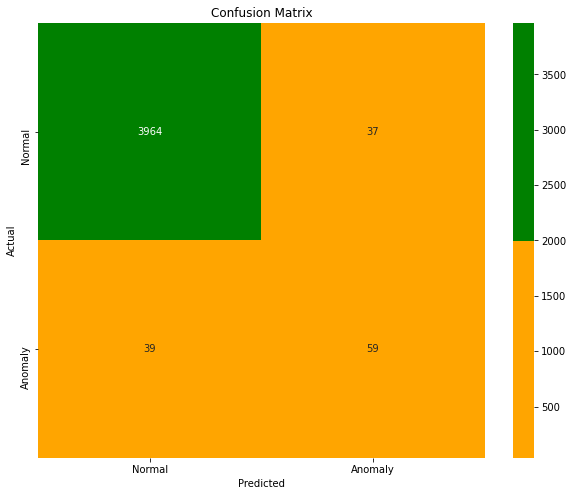

<IPython.core.display.Javascript object>

In [41]:
VisualizationHelper().draw_confusion_matrix(y_test, y_label)

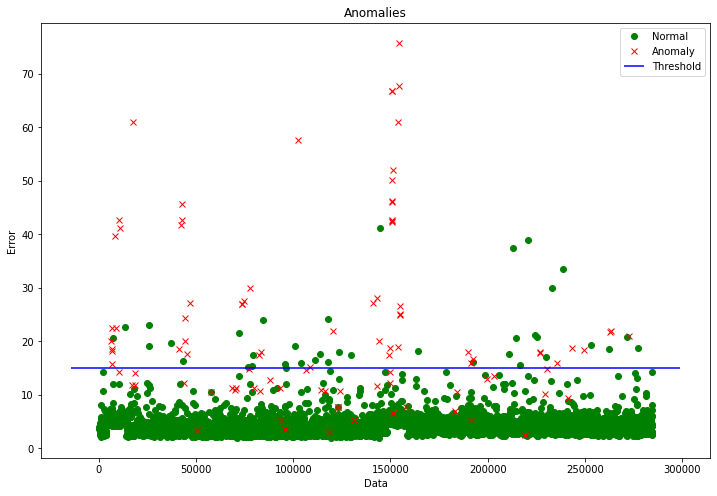

<IPython.core.display.Javascript object>

In [42]:
VisualizationHelper().draw_anomaly(y_test, errors, THRESHOLD)

## Variational Auto Encoders

In [43]:
from tensorflow.keras import backend as K


<IPython.core.display.Javascript object>

In [44]:
original_dim = X_train.shape[1]

input_shape = (original_dim,)
intermediate_dim = 12
latent_dim = 2

inputs = Input(shape=input_shape, name="encoder_input")
x = Dense(intermediate_dim, activation="relu")(inputs)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

<IPython.core.display.Javascript object>

In [45]:
from tensorflow.keras import backend as K


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(
        shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=0.1
    )
    return z_mean + K.exp(z_log_sigma) * epsilon


z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

<IPython.core.display.Javascript object>

#### Create Model

In [46]:
# Create encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 29)]         0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 12)           360         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            26          dense_8[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            26          dense_8[0][0]                    
____________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [48]:
# Create decoder
latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
x = Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = Dense(original_dim, activation="sigmoid")(x)
decoder = Model(latent_inputs, outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                36        
_________________________________________________________________
dense_12 (Dense)             (None, 29)                377       
Total params: 413
Trainable params: 413
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [49]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name="vae_mlp")

<IPython.core.display.Javascript object>

In [50]:
reconstruction_loss = keras.losses.mse(inputs, outputs)
reconstruction_loss *= original_dim

<IPython.core.display.Javascript object>

In [51]:
# loss function: the sum of a reconstruction term, and the KL divergence regularization term.

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

<IPython.core.display.Javascript object>

In [52]:
vae.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 29)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 412         encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 29)           413         encoder[0][2]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 12)           360         encoder_input[0][0]              
____________________________________________________________________________________________

<IPython.core.display.Javascript object>

#### Train Model

In [53]:
history = vae.fit(
    X_train,
    X_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    validation_data=(X_test, X_test),
)

Epoch 1/20
513/513 [==============================] - 1s 985us/step - loss: 54.6646 - accuracy: 0.1811 - val_loss: 48.9446 - val_accuracy: 0.2588
Epoch 2/20
513/513 [==============================] - 0s 829us/step - loss: 50.1414 - accuracy: 0.2669 - val_loss: 47.5803 - val_accuracy: 0.3023
Epoch 3/20
513/513 [==============================] - 0s 805us/step - loss: 49.1086 - accuracy: 0.3048 - val_loss: 46.8387 - val_accuracy: 0.3264
Epoch 4/20
513/513 [==============================] - 0s 804us/step - loss: 48.5409 - accuracy: 0.3218 - val_loss: 46.3848 - val_accuracy: 0.3369
Epoch 5/20
513/513 [==============================] - 0s 814us/step - loss: 48.1097 - accuracy: 0.3332 - val_loss: 46.0031 - val_accuracy: 0.3464
Epoch 6/20
513/513 [==============================] - 0s 862us/step - loss: 47.7748 - accuracy: 0.3442 - val_loss: 45.7590 - val_accuracy: 0.3569
Epoch 7/20
513/513 [==============================] - 0s 824us/step - loss: 47.5256 - accuracy: 0.3566 - val_loss: 45.5431 -

<IPython.core.display.Javascript object>

### Evaluate Model

In [54]:
score = vae.evaluate(X_test, X_test, verbose=1)

129/129 [==============================] - 0s 574us/step - loss: 44.8370 - accuracy: 0.4184


<IPython.core.display.Javascript object>

In [55]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 44.836997985839844
Test Accuracy: 0.4183947443962097


<IPython.core.display.Javascript object>

#### Visualize errors

In [56]:
threshold = 10.00
y_pred = vae.predict(X_test)
y_dist = np.linalg.norm(X_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

<IPython.core.display.Javascript object>

In [57]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4001
           1       0.46      0.87      0.60        98

    accuracy                           0.97      4099
   macro avg       0.73      0.92      0.79      4099
weighted avg       0.98      0.97      0.98      4099



<IPython.core.display.Javascript object>

In [58]:
roc_auc_score(y_test, y_label)

0.9211765936067003

<IPython.core.display.Javascript object>

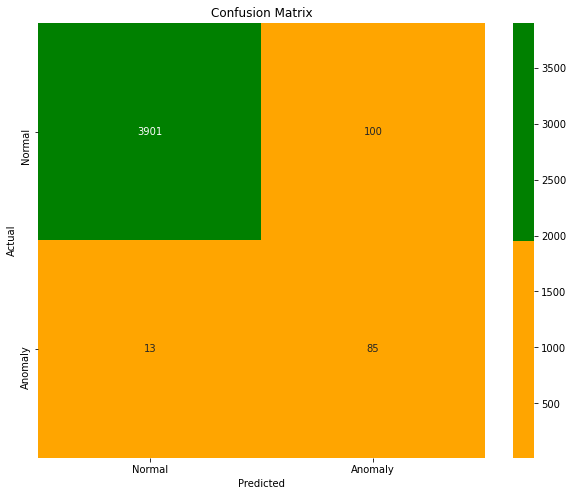

<IPython.core.display.Javascript object>

In [59]:
VisualizationHelper().draw_confusion_matrix(y_test, y_label)

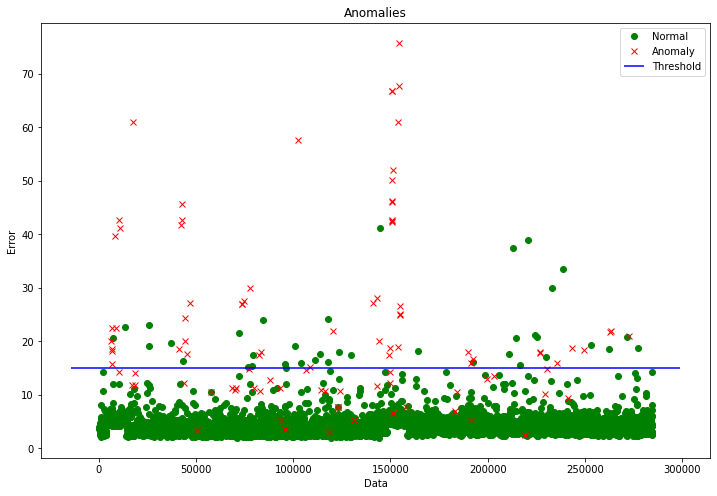

<IPython.core.display.Javascript object>

In [60]:
VisualizationHelper().draw_anomaly(y_test, errors, THRESHOLD)